In [1]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from PIL import Image
from functools import partial
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import json
import amornsaensuk as am

def up_sampling(fire_name, nml_name):
    n_fire = len(fire_name)
    n_nml = len(nml_name)
    up = np.abs(n_fire - n_nml)

    if n_fire < n_nml:
        up_time = (up//n_fire) + 1
        up_remain = up%n_fire
        fire_name = fire_name * up_time
        fire_name = fire_name + fire_name[:up_remain]
    else:
        up_time = (up//n_nml) + 1
        up_remain = up%n_nml
        nml_name = nml_name * up_time
        nml_name = nml_name + nml_name[:up_remain]

    return fire_name, nml_name

In [2]:
fname, label = am.load_fname_label('./data/Train')
fname_test, tst_label = am.load_fname_label('./data/Test')

dirname = glob.glob('./data/*')
add_fname = glob.glob(dirname[0]+'/*')
add_nm_name = []
for d in dirname[1:-2]:
    add_nm_name.extend(glob.glob(d + '/*'))


size = (150,150)
fname_val = fname[:100]
fname_val.extend(fname[-100:])
fname_val.extend(add_fname[:10])
fname_val.extend(add_nm_name[:50])
fname_test_add = (add_fname[10:20])
fname_test_add.extend(add_nm_name[50:100])
fname_train = fname[100:-100]
fname_train.extend(add_fname[20:])
fname_train.extend(add_nm_name[100:])



In [3]:
fire = []
nml = []
for name in fname_train:
    if re.search('Fire',name):
        fire.append(name)
    else:
        nml.append(name)

In [4]:
fire, nml = up_sampling(fire,nml)

fname_train = fire + nml

In [5]:
x_t, y_t = am.load_xy(fname_train,size)
x_v, y_v = am.load_xy(fname_val,size)
x_tst,y_tst = am.load_xy(fname_test,size)
x_tst_add,y_tst_add = am.load_xy(fname_test_add,size)

creating x,y: 100%|██████████| 60/60 [00:00<00:00, 80.41it/s]


In [6]:
datagen_train = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

datagen_val = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen_test = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen_test_add = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')


In [7]:

X_val = []
y_val = []
datagen_train.fit(x_t)
datagen_val.fit(x_v)
datagen_test.fit(x_tst)
datagen_test_add.fit(x_tst_add)
X_train, y_train = am.augment_data(x_t,y_t,datagen_train,6000)
X_val, y_val = am.augment_data(x_v,y_v, datagen_val, 600)
X_test, y_test = am.augment_data(x_tst,y_tst, datagen_val, 600)
X_test_add, y_test_add = am.augment_data(x_tst_add,y_tst_add, datagen_val, 600)

data augmenting:: 6016it [00:23, 259.62it/s]                          
data augmenting:: 640it [00:02, 263.67it/s]                         
data augmenting:: 672it [00:02, 282.86it/s]                         
data augmenting:: 640it [00:02, 282.15it/s]                         


## CNN

In [8]:

model = Sequential()
model.add(Conv2D(64, 3, padding="same", activation="relu", input_shape=(150,150,3)))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))


model.add(Conv2D(128, 5,strides=(2,2), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256,activation="relu",activity_regularizer=l2(10e-2)))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 128)       204928    
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 19, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0

In [9]:
save_name = 'last_cnn_1_batchNorm'

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=20,
                              verbose=0,
                              mode='auto')
model_save = ModelCheckpoint('./models/'+ save_name+'.hdf5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                            verbose=0)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_delta=1e-4,
                              mode='min')
tb = TensorBoard(log_dir='./logsCloud/'+save_name)

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

train_log_cnn = model.fit(X_train,y_train,
                          batch_size=128,
                          epochs=100,
                          validation_data=(X_val, y_val),
                         callbacks=[early_stopping, model_save, reduce_lr])

Epoch 1/100
48/48 [==============================] - 137s 3s/step - loss: 2.7860 - accuracy: 0.5187 - val_loss: 0.6932 - val_accuracy: 0.4156
Epoch 2/100
48/48 [==============================] - 136s 3s/step - loss: 0.6772 - accuracy: 0.7287 - val_loss: 0.6956 - val_accuracy: 0.4156
Epoch 3/100
48/48 [==============================] - 138s 3s/step - loss: 0.6290 - accuracy: 0.8013 - val_loss: 0.7860 - val_accuracy: 0.4156
Epoch 4/100
48/48 [==============================] - 139s 3s/step - loss: 0.5510 - accuracy: 0.8389 - val_loss: 0.8207 - val_accuracy: 0.4156
Epoch 5/100
48/48 [==============================] - 138s 3s/step - loss: 0.5143 - accuracy: 0.8548 - val_loss: 0.6688 - val_accuracy: 0.4740
Epoch 6/100
48/48 [==============================] - 138s 3s/step - loss: 0.4676 - accuracy: 0.8553 - val_loss: 0.7173 - val_accuracy: 0.4448
Epoch 7/100
48/48 [==============================] - 137s 3s/step - loss: 0.4668 - accuracy: 0.8595 - val_loss: 0.7441 - val_accuracy: 0.4269
Epoch 

In [23]:
model.save('last_cnn_BN_manualsave.hdf5')
hist = train_log_cnn.history
del hist['lr']
with open(save_name+'_log.json', 'w') as f:
    json.dump(hist, f)

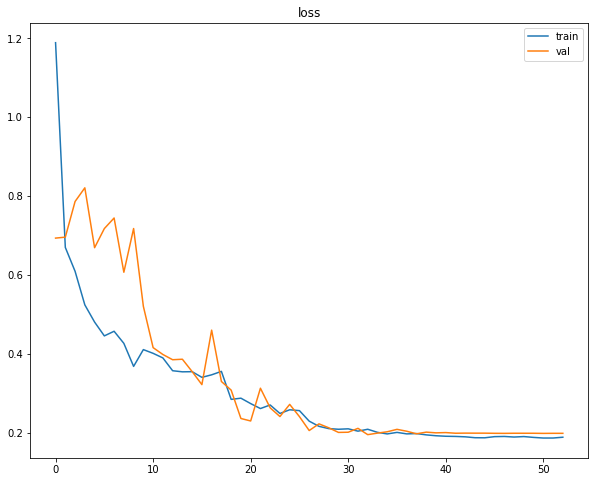

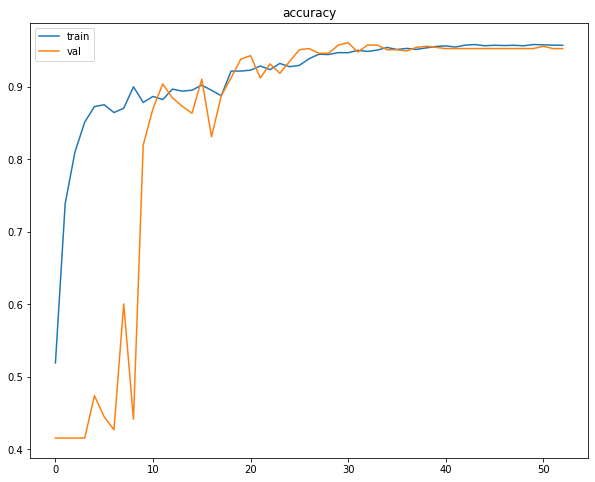

In [19]:
am.plot_train_log(train_log_cnn.history)

In [20]:
prediction = model.predict(X_test)
prediction = [1 if x >=0.5 else 0 for x in prediction]

am.model_eval(prediction,y_test)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 300 | 17
       "0"| 34  | 281
------------------------------

accuracy =  0.9193037974683544
precision =  0.8982035928143712
recall =  0.9463722397476341
F1 =  0.9216589861751151


(300, 34, 17, 281)

In [21]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 3s 127ms/step - loss: 0.2626 - accuracy: 0.9193


[0.26256459951400757, 0.9193037748336792]

In [22]:
prediction = model.predict(X_test_add)
prediction = [1 if x >=0.5 else 0 for x in prediction]

am.model_eval(prediction,y_test_add)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 106 | 0
       "0"| 39  | 487
------------------------------

accuracy =  0.9382911392405063
precision =  0.7310344827586207
recall =  1.0
F1 =  0.844621513944223


(106, 39, 0, 487)